<h1>Fitting IVT mechanistic model to Akama dataset<h1>

In this notebook, we will be showing how the figures in our paper were generated. We will be doing the following
    
    1. Performing local MAP optimization to fit our model to the dataset of Akama et al.
    2. Using a linearized model approximation to estimate a parameter covariance matrix. 
    3. Visualizing model fitting by plotting against fitting dataset
    4. Validating our model on new data (without fitting parameters)

<b>1. Importing required packages<b>

In [347]:
using Pkg
Pkg.activate("../IVTmodel")
Pkg.instantiate()
include("../modules/IVTmodel.jl")

  Activating project at `C:\Users\ChemeGrad2021\Documents\Braatz Group\MRNA Synthesis\Published code\IVT2.0\IVTmodel`
Precompiling project...
  ? Metrics


plotMg2PPiphasediagram (generic function with 1 method)

In [348]:
include("../modules/IVTmodel.jl")

plotMg2PPiphasediagram (generic function with 1 method)

<b>2: Setting up model and importing data<b>

The following cell creates an object representing the parameters used in our model, whether they are fitted parameters or not, and their Bayesian priors. 
    
We also import required data for fitting and validation. 

In [345]:
#Generates settings for parameters used
fittingmodel = setupmodel_IVT4()
#Imports calibration data from csv files
modeldata = importakamadata()#Note: Data for NTP curves 4 and 5 multiplied by 1.5 to make more consistant
osumidata = importosumidata()
ourpHdata = importosumidata(phfilename = "../data/pH/ourpH.csv")
#Imports PPiase validation data
PPiasedata = importakamaPPiasedata();

Model has 25 fitted parameters, 17 of which have a bayesian prior


<b>3: Optimizing Model<b>
    
We next fit the model to the Akama data set using MAP estimation. While in our work multistart optimization was used for this nonconvex problem, we use a local optimization here for simplicity. We will use a manually selected starting point that is near the optimum but not optimal.  

In [349]:
#Start at a manually selected warm start point
modorigin = [
  3.93#k_i_akama
  3.93#k_i_guo
  5.13#k_e_akama
  5.13#k_e_guo
  #3.71
  2.30#k_on
  log10(0.0006722601121132597)
  log10(0.0007918240342381915)
  log10(10.0)#nMg
  -3.1210353022517765#kippi
  log10(exp(4.0))#K_Mg
  log10(exp(2.86))#K_uo
  #-6.224527413308775
  #-3.8
 -4.50
 -7.5
 -9.2
 log10(4.0)
 0.0
 #log10(0.0208)
 # 0 #If using "ppiaseuncertainty = true" uncomment this line
 #-3.6695 #If using "ppiaseuncertainty = true" uncomment this line
 -0.26
  1.65
  4.47
  #6.91
  #2.08
  #9.02
  #3.30
  #6.91
  #2.08
  #3.32#KHMgPPi
  4.0227#KMgNTP
  #1.6049#KMg2NTP
  6.904370333455767#5.23
  3.99#Mg2PPi
 -3.95
]


modorigin = [
  4.00146982821576
  4.3445403935387244
  5.190748643050945
  5.3964574398567995
  2.30#k_on
 -3.7126139599282033
 -4.132894306607353
  log10(4.0)#nMg
  -3.1210353022517765#kippi
  log10(exp(4.0))#K_Mg
  log10(exp(2.86))#K_uo
 -7.528892114474933
 -9.283657218610035
  1.1584762469701004
  0.0#gamma
  0.4918949817994031
  1.6471707660497328
  4.654587904073317
  3.32
  4.226535555197134
  1.8481863799690796
  5.303909786365148
  3.983606246066889
 -3.903933681060077]

modoriginparams = fullparameterset(fittingmodel,modorigin)
akama_pHresidual = (model,data,parameters) -> akamaresidual(model,data,osumidata,parameters)
printresidual(fittingmodel,modeldata,osumidata,modorigin)

Total Residual:                        1799.0
Components of residual:
Concentration Trajectories (Figure 2): 790.7
Initial Reaction Rate (Figure 3A):     503.0
Mg2PPi solubility (Figure 3B):         206.3
Parameter priors:                      239.3
pH Effect Data:                        59.7


In [350]:
guoresidual = (model,data,parameters) -> customresidualeval(model,data,osumidata,"../data/external/guo/guofig1_40.csv",parameters; seperateDNA = true, OAccounterion = false)

#3378 (generic function with 1 method)

In [351]:
guoresidual(fittingmodel, modeldata,modorigin)

3373.791617795361

We then optimize the model and calculate a covariance matrix. Note that the loss should be decreasing until a tolerance is reached. 

In [352]:
#optim=localopt(fittingmodel, modeldata,300,modorigin,akama_pHresidual,verbose = true)
optim=localopt(fittingmodel, modeldata,300,modorigin,guoresidual,verbose = true)
fittedparamslist = optim[4]
fittedparams = fullparameterset(fittingmodel,fittedparamslist)
#covariancemat = getcovariancematrix(fittingmodel,modeldata,osumidata,fittedparamslist);
covariancemat = getcovariancematrix(fittingmodel,modeldata,osumidata,fittedparamslist,customfile = true,customfilename = "../data/external/guo/guofig1.csv", NaperNTP = 3.77, seperateDNA = true, OAccounterion = false);
writedlm( "../outputs/fittedparameters.csv",  fittedparamslist, ',')
writedlm( "../outputs/covariancematrix.csv",  covariancemat, ',')
printresidual(fittingmodel,modeldata,osumidata,fittedparamslist)

3373.7723782612466
34947.05265091363
3185.092402149495
2675.4902905074327
2361.145684123736
2254.448875399097
2455.3494435361754
2097.6682166442465
2020.880720836492
2007.749977053609
1971.6225023893485
1922.575856747325
1852.692651672192
1848.8967656030322
1837.2809595986887
1818.4968068872672
1786.4014639306797
1753.533537246051
1736.1541999802812
1724.1568729262578
1712.2601340340861
1683.546448334936
1650.712805237162
1624.922735676622
1613.2219898560156
1607.0229254102583
1599.6633359638613
1582.8268671429455
1558.2645467873292
1533.2047467446607
1562.2884252747442
1490.6412617043688
1481.127117931574
1471.3384797088604
1467.8798359619113
1464.5359092183148
1462.277912105745
1460.7735930530473
1454.9977852811023
1445.9760967671082
1439.1441358425714
1436.4815587381167
1435.1041890655283
1434.1146921729528
1432.8032155667988
1430.9382758036966
1427.9377526402614
1424.4080666296136
1419.1129371973775
1413.3705745128564
1409.1117418204608
1401.4608982118916
1393.88480011629
1399.1735

We can investigate the source of the loss between the datasets used in our calibration set. In this case, residuals are roughly proportional to the amount of "information" we get from each source. 

<b>4: Plotting Figures from Paper - Fitting Data<b>
    
Now that we have have successfully fit a set of parameters to our model, we can think about plotting our data alongside our model predictions. 

In [353]:
println((fittedparams))
println(fittedparams.k_i*1000/fittedparams.k_e)
println(1800*1000/(10^(4.72)))

(k_dT7 = 0.0, k_i = 9965.109077425002, k_i_guo = 1771.753492835955, k_e = 152210.74384704794, k_e_guo = 863946.9113635311, k_off = 4320.0, k_on = 1114.4697955571773, K_1 = 0.0002627796879071918, K_2 = 2.806778750871103e-6, nMg = 15.201389157752658, Ki_PPi = 5.522946482588994e-5, K_Mg = 38.69410052077155, K_u0 = 13.06812485931196, K_a = 5.5563295870149294e-8, K_b = 3.7703287111148347e-10, k_pH = 12.372051938378874, gamma = 1.0, theta = 0.0208, K_ds = 1.0, kPPiase = 1.0, KMPPiase = 0.000214, k_precip = 3.375353922147663, B = 43.03055930316469, k_d = 37716.07546607984, K_HNTP = 3.0669027151623075e6, K_HMgNTP = 101.93421904967055, K_HPPi = 1.0471285480508986e9, K_HMgPPi = 1812.6521932234868, K_H2PPi = 1.8197008586099825e6, K_H2MgPPi = 128.82495516931337, K_MgNTP = 7399.833872185456, K_Mg2NTP = 43.43483485912946, K_MgPPi = 97085.13903416115, K_Mg2PPi = 5191.706096368035, Mg2PPi_eq = 0.00012377786533177175, K_MgPi = 43.19592714369777, K_HPi = 4.171987514076607e6, K_NaPi = 5.88843655355589, K

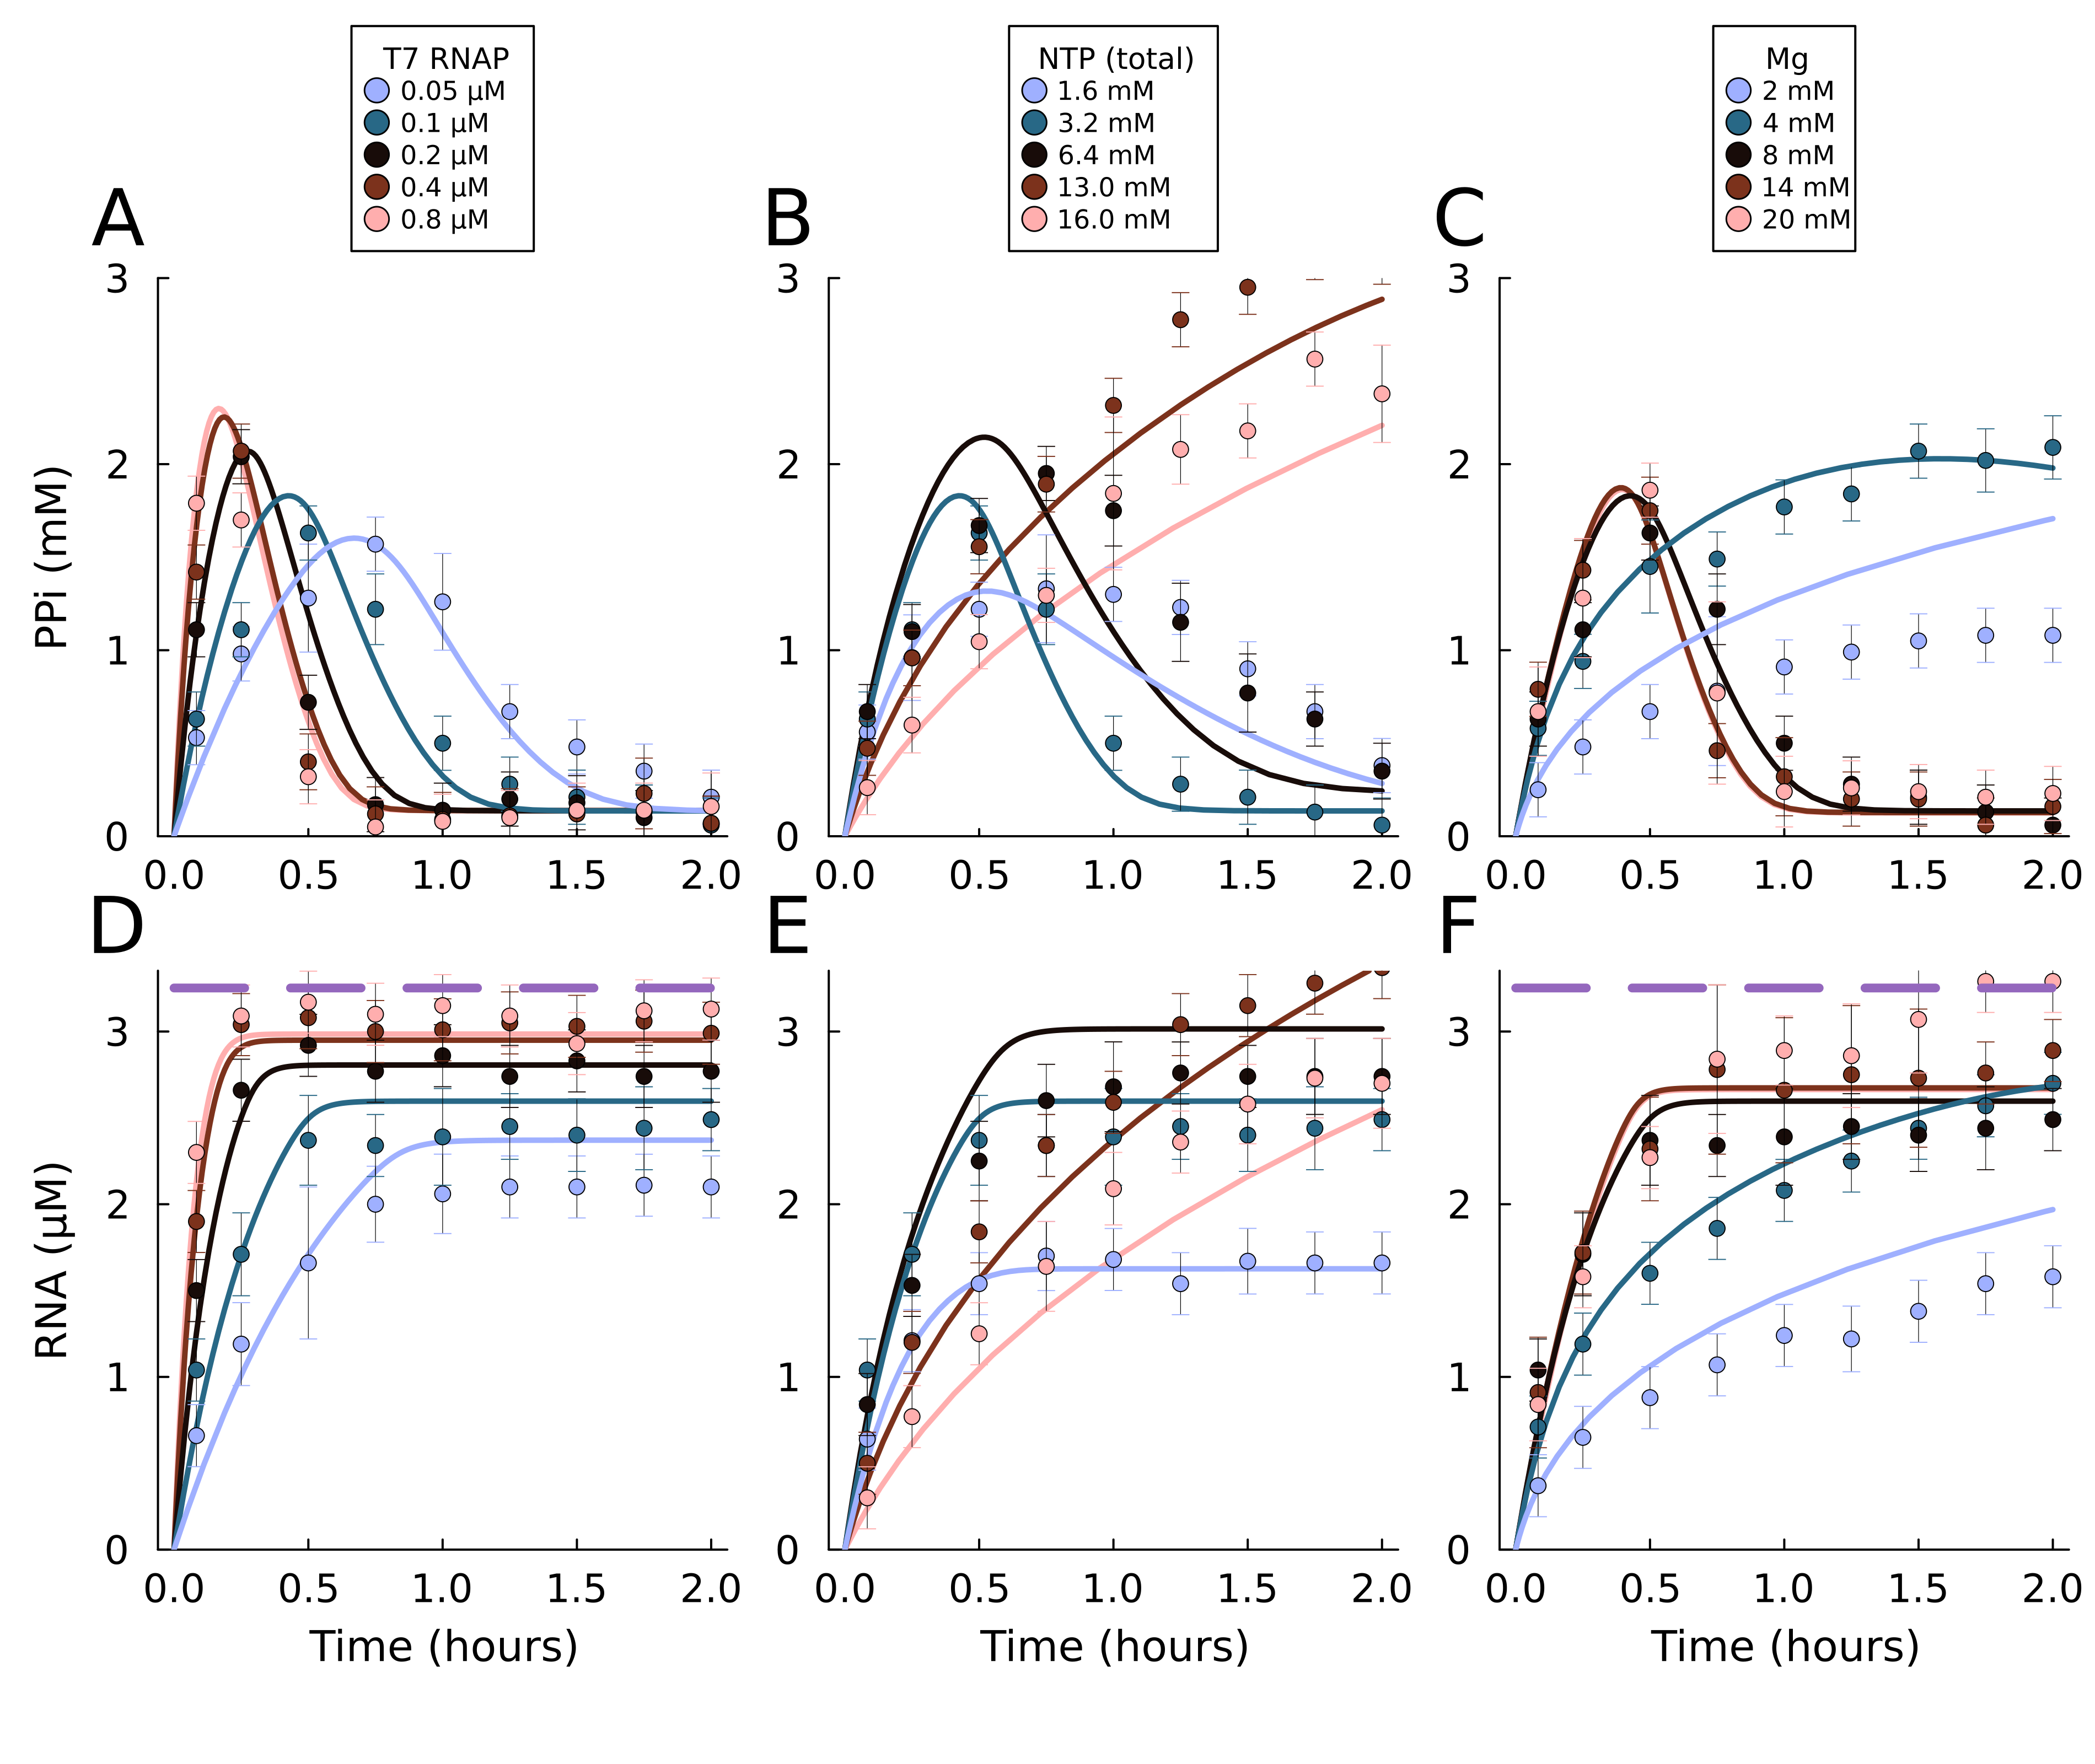

In [354]:
plt = revision1plot1(fittingmodel,modeldata, fittedparams, covariancemat, true,false)
plot!(dpi = 400)
savefig(plt,"../figures/GM6_27/akamamain.png")
plt

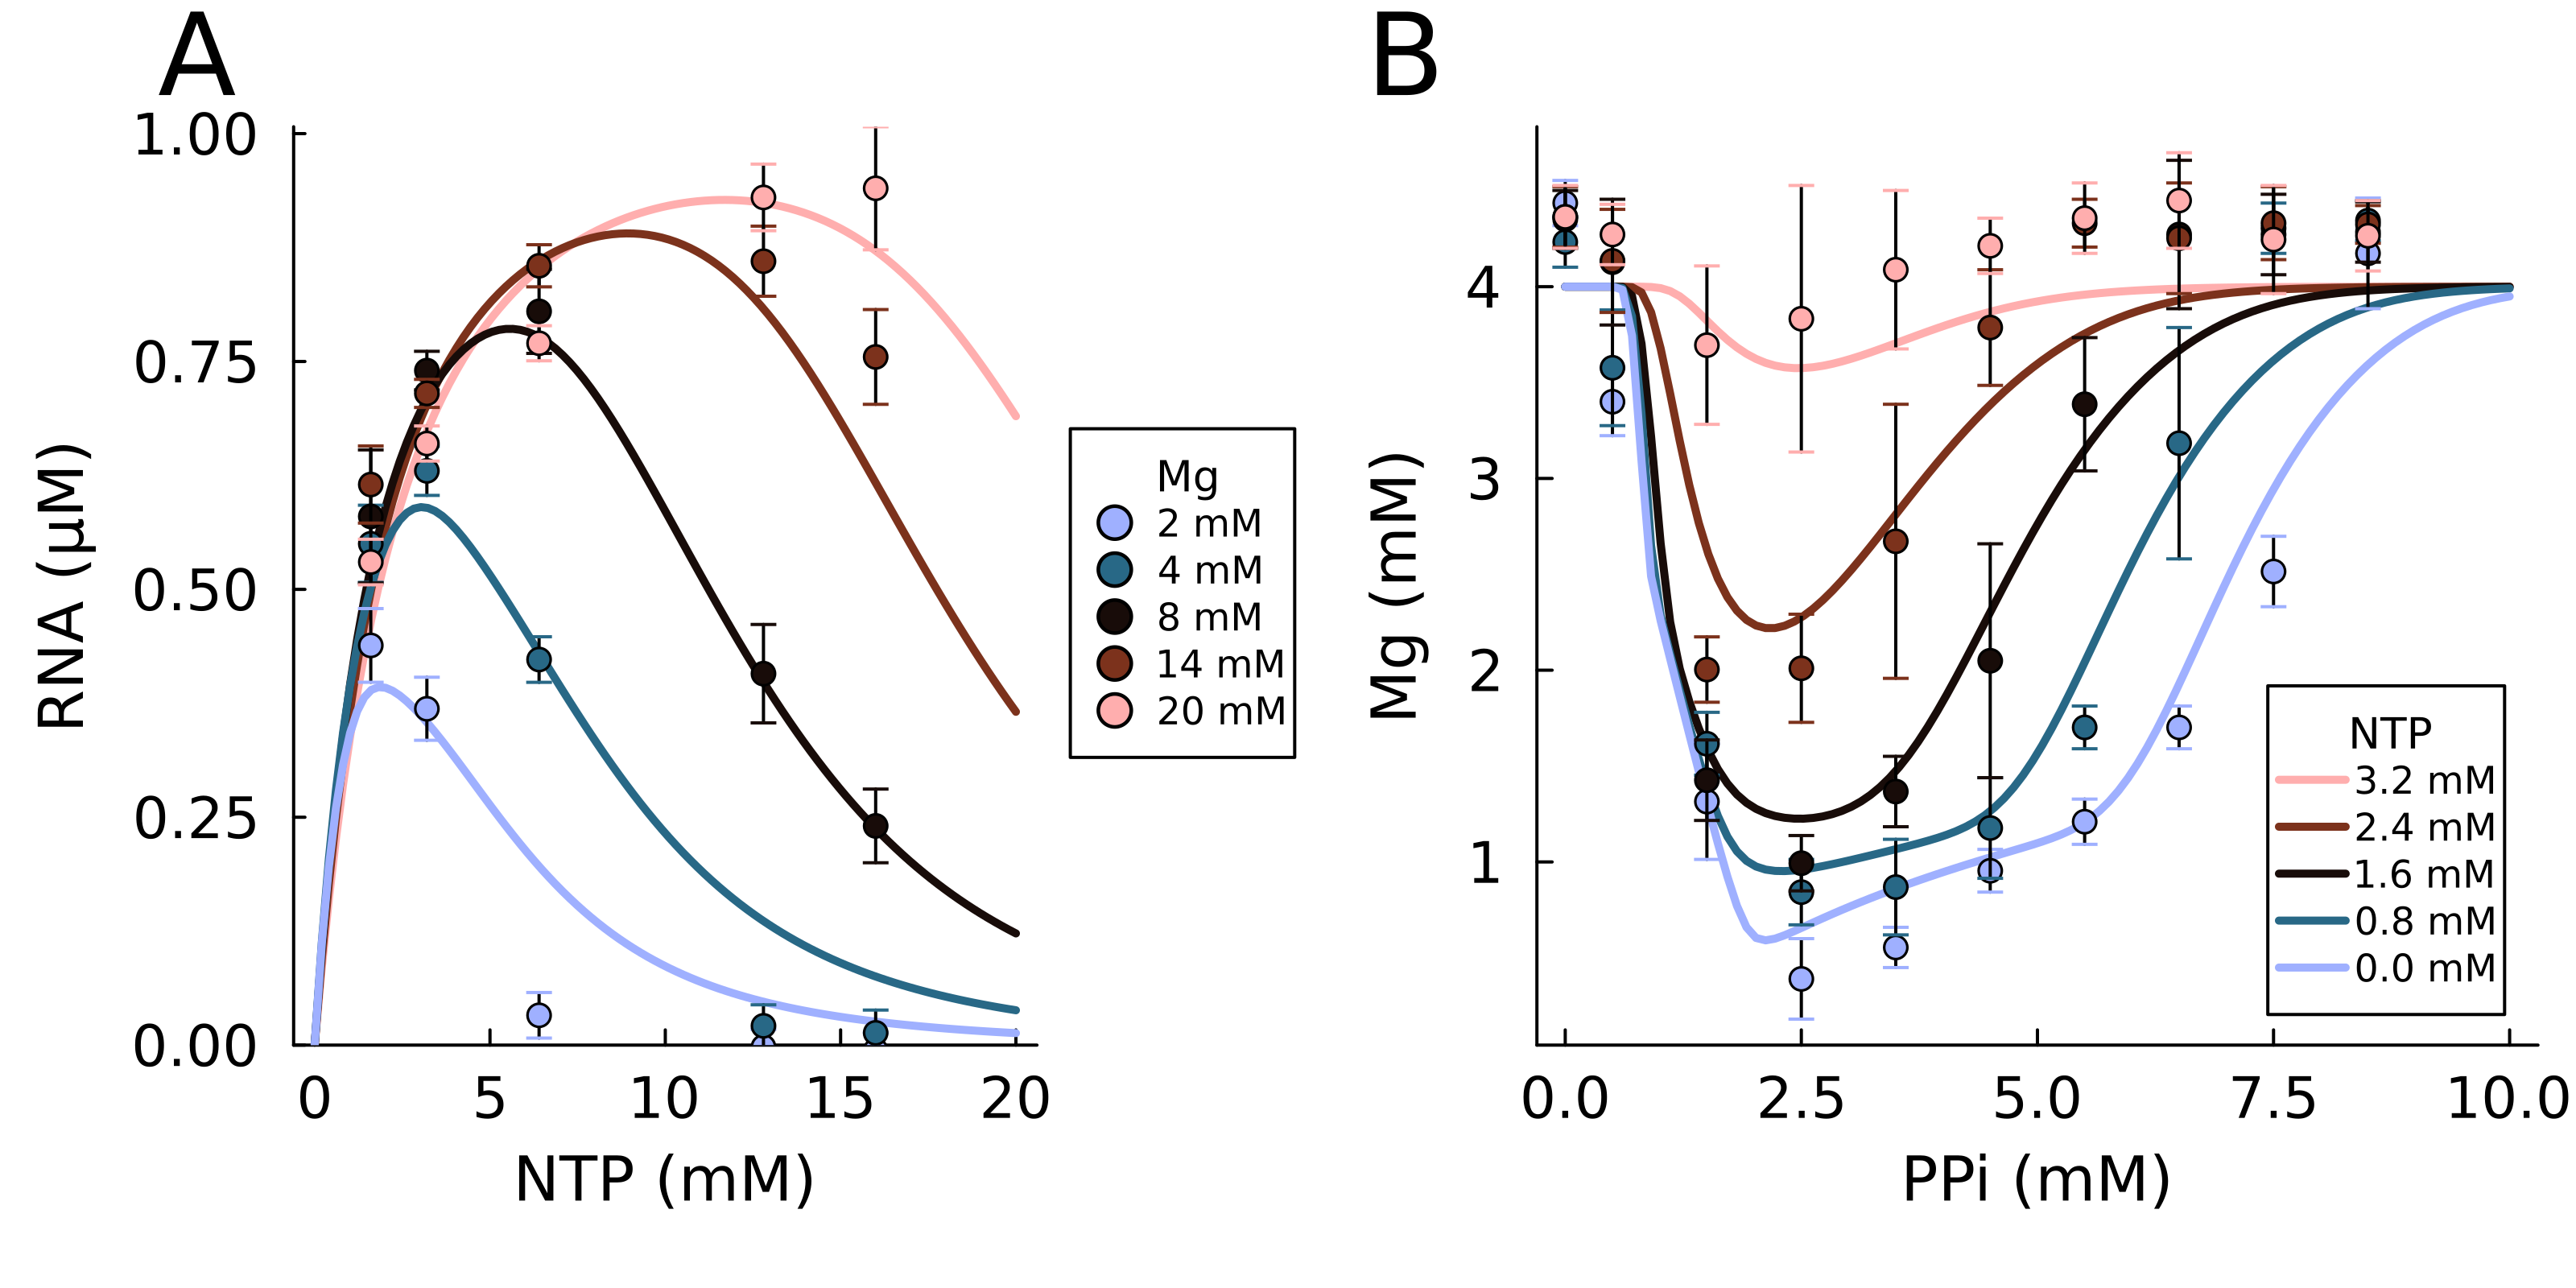

In [355]:
plt = revision1plot2(fittingmodel,modeldata, fittedparams, covariancemat, true,false)
plot!(dpi = 400)
savefig(plt,"../figures/GM6_27/akamarate.png")
plt

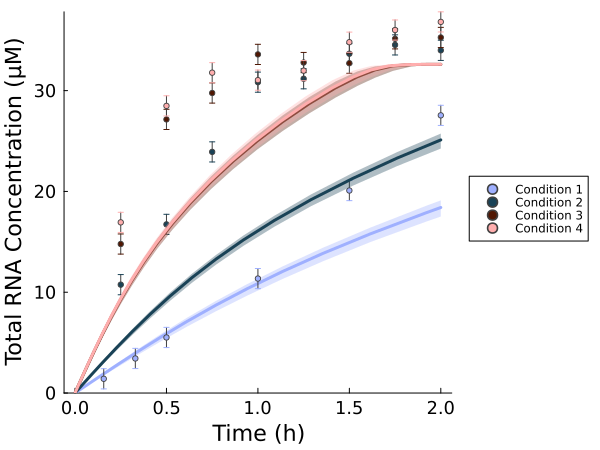

In [356]:
#Note: Following effective T7 concentration from above
preground3filename = "../data/external/guo/guokinetics.csv"
plt = plotfromcsv(fittingmodel,fittedparamslist,covariancemat,preground3filename,range = [1,2,3,4],plotsize = (600,450),dataerrorbars = true, multiplot = false,maximumyield = false, precip = true, NaperNTP = 3.77, seperateDNA = true, OAccounterion = false)

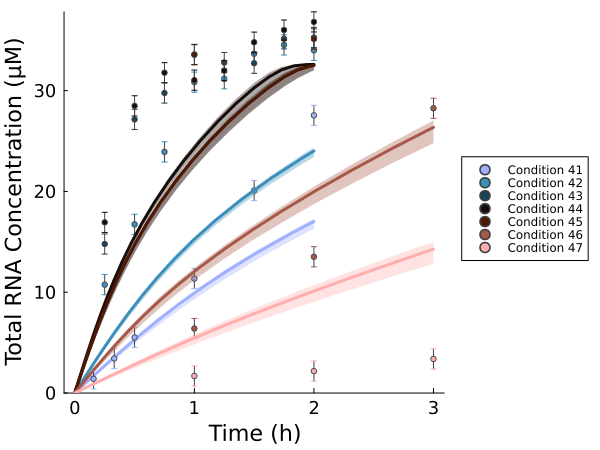

In [357]:
#Note: Following effective T7 concentration from above
preground3filename = "../data/external/guo/guofig1.csv"
plt = plotfromcsv(fittingmodel,fittedparamslist,covariancemat,preground3filename,range = [41,42,43,44,45,46,47],plotsize = (600,450),dataerrorbars = true, multiplot = false,maximumyield = false, precip = true, seperateDNA = true, OAccounterion = false, NaperNTP = 3.77)

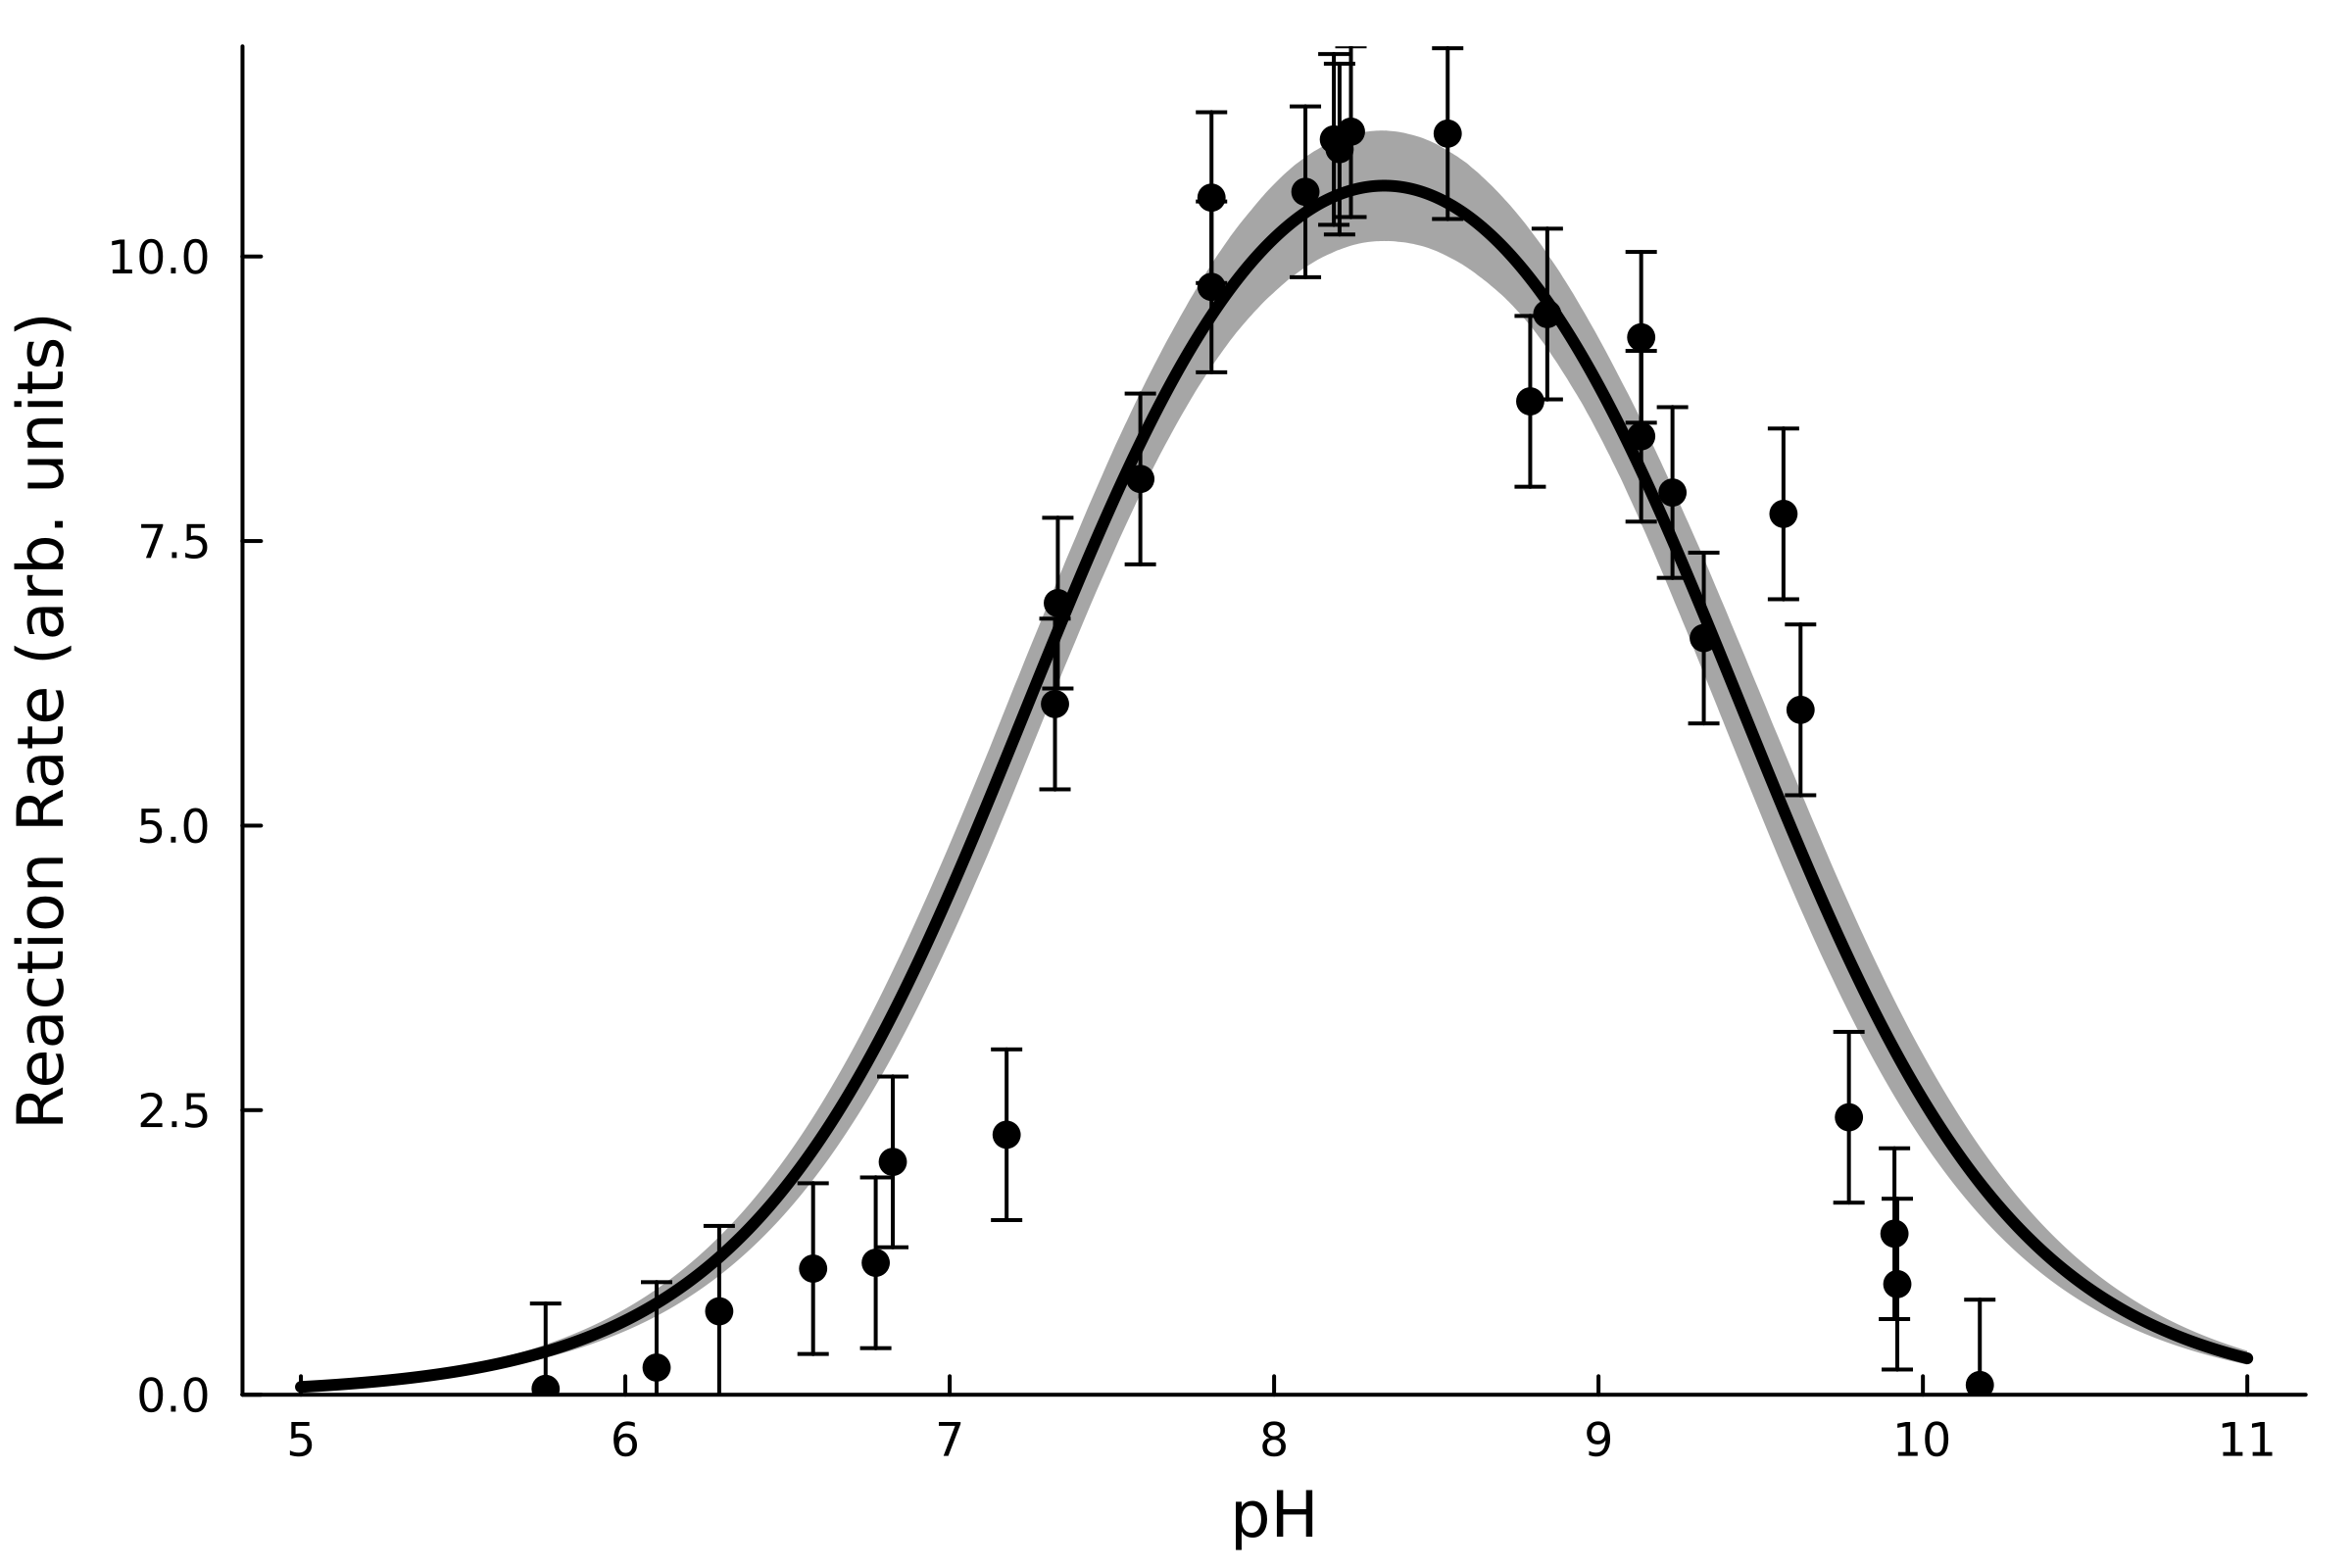

In [358]:
plt = pHplotting(fittingmodel,osumidata, fittedparamslist, covariancemat)
plot!(dpi = 400)
savefig(plt,"../figures/GM6_27/osumipH.png")
plt

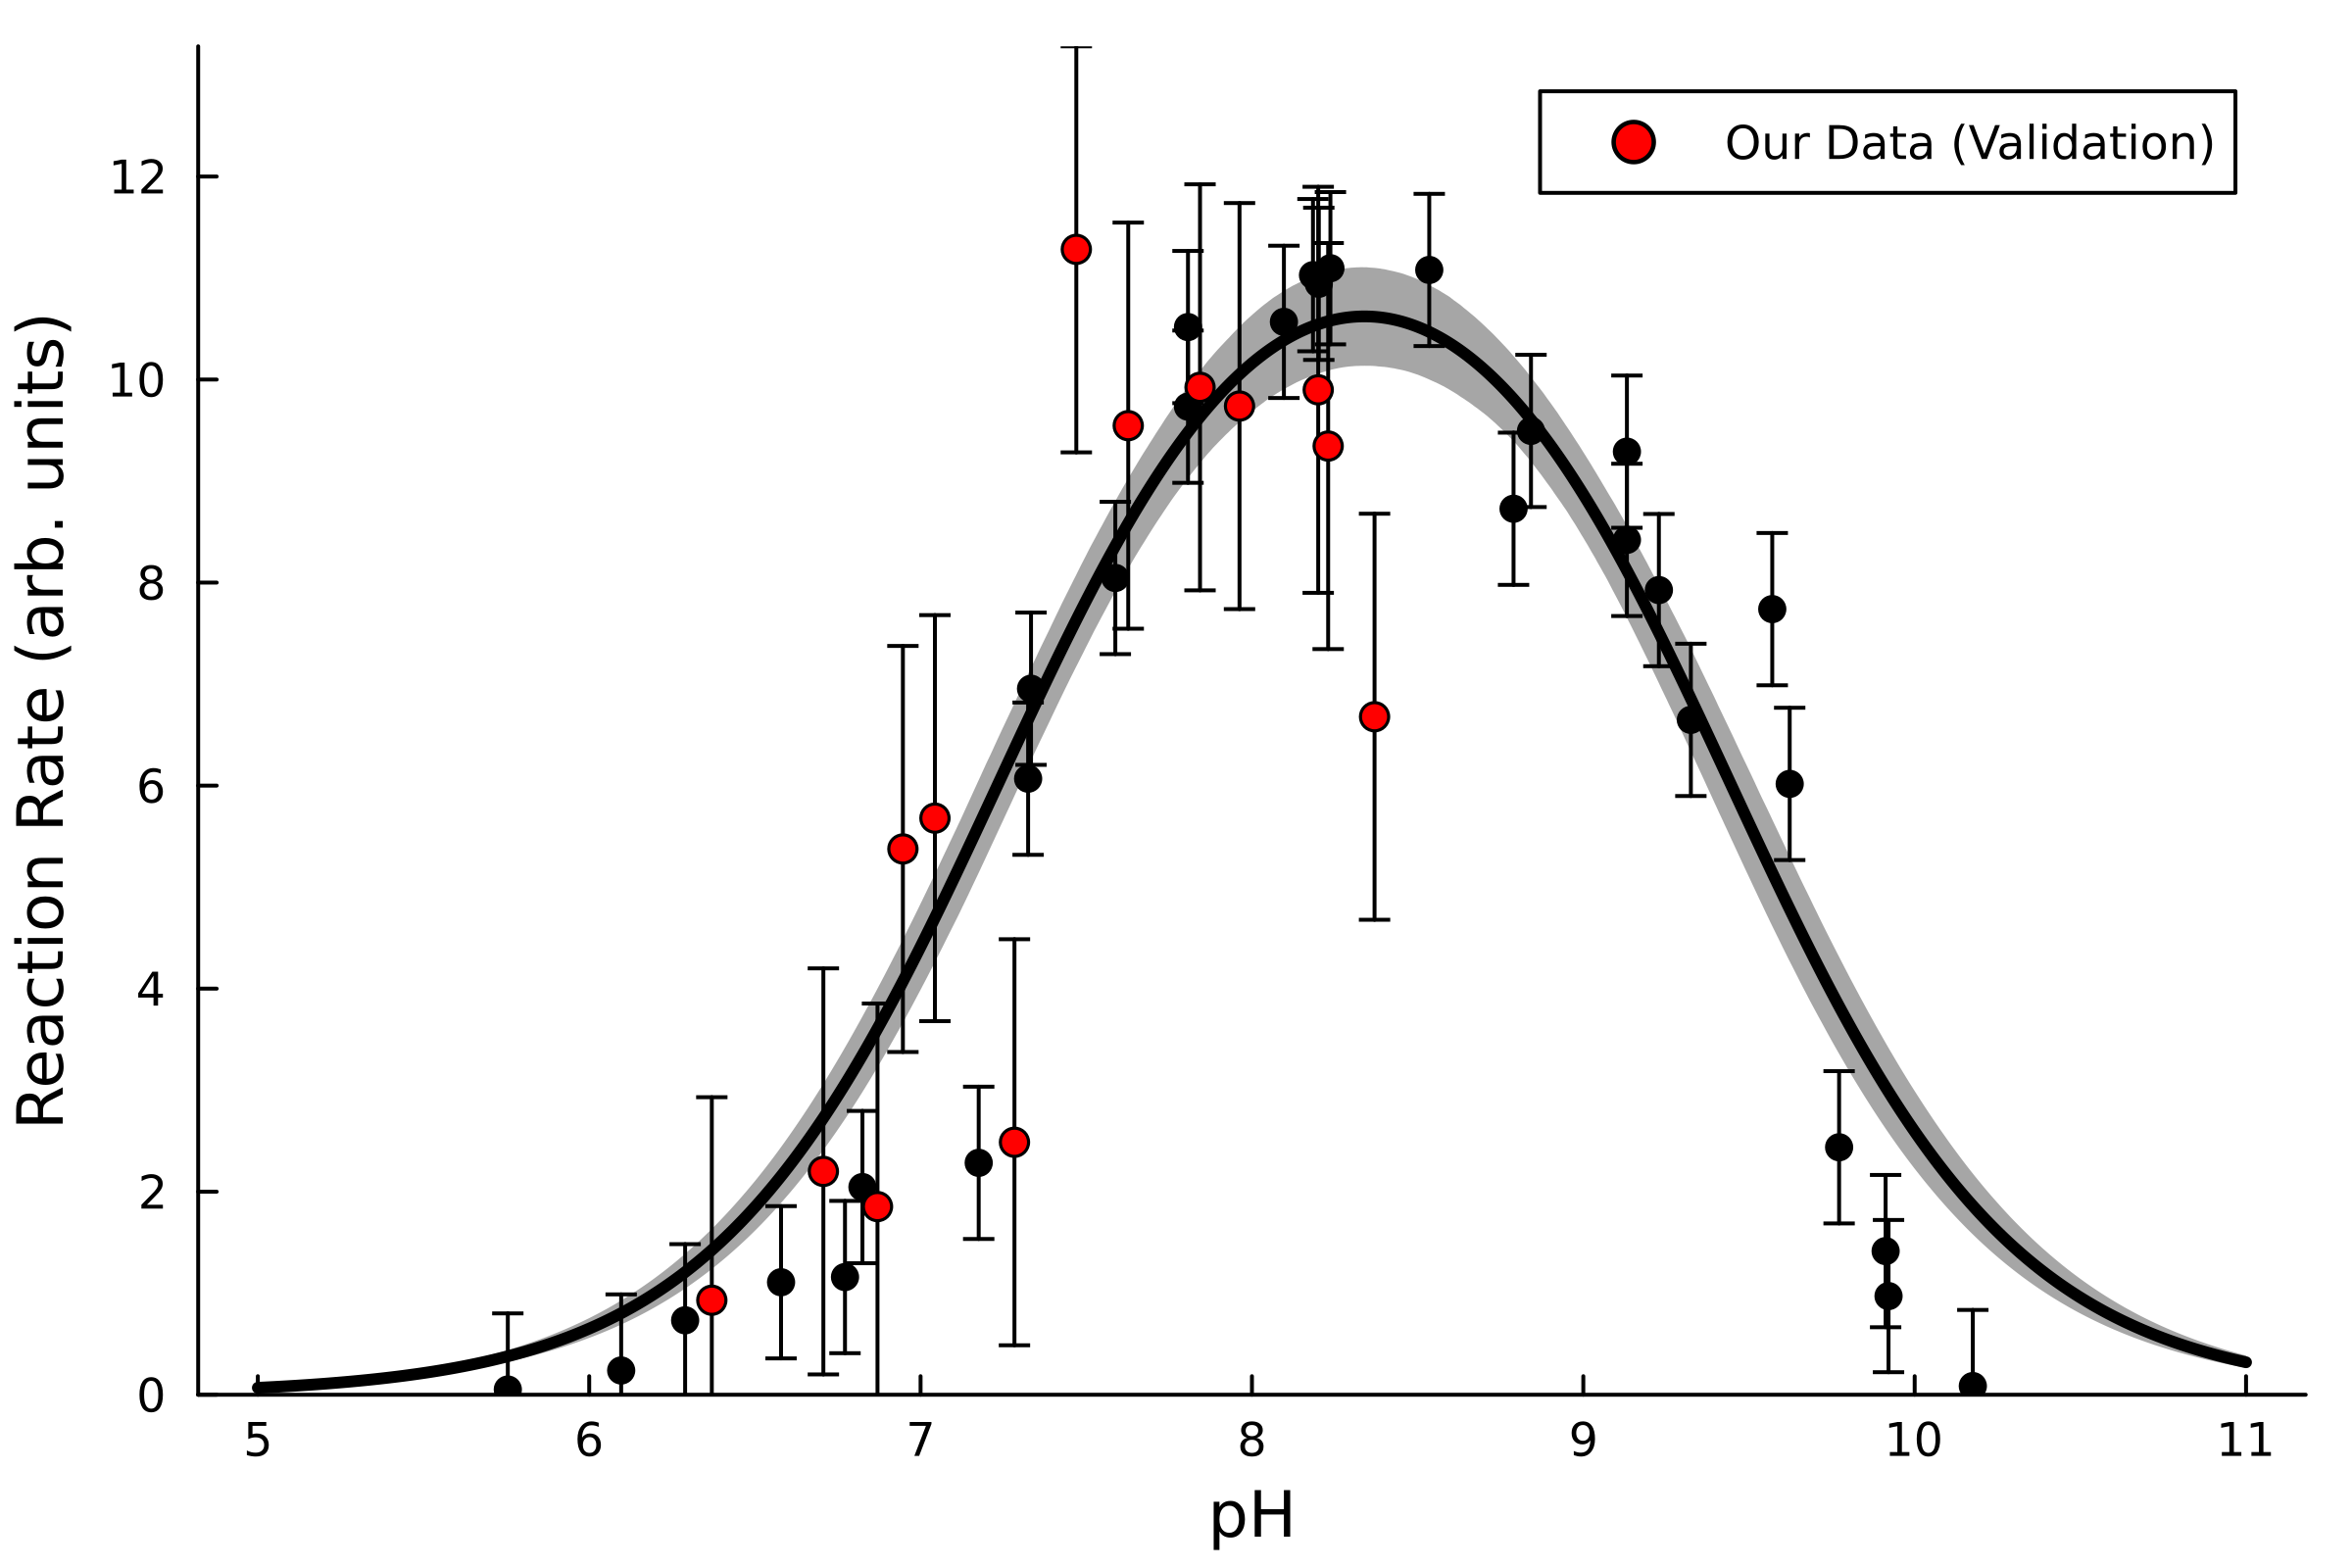

In [359]:
scatter!(plt,ourpHdata[:,1],ourpHdata[:,2],yerror = 2,color = :red,label= "Our Data (Validation)")
savefig(plt,"../figures/GM6_27/ourpH.png")
plt

<b>5: Plotting Figures from Paper - Validation Data<b>
    
Finally, we can apply our model to new data. See the main body of our paper for a complete description of what this data represents.

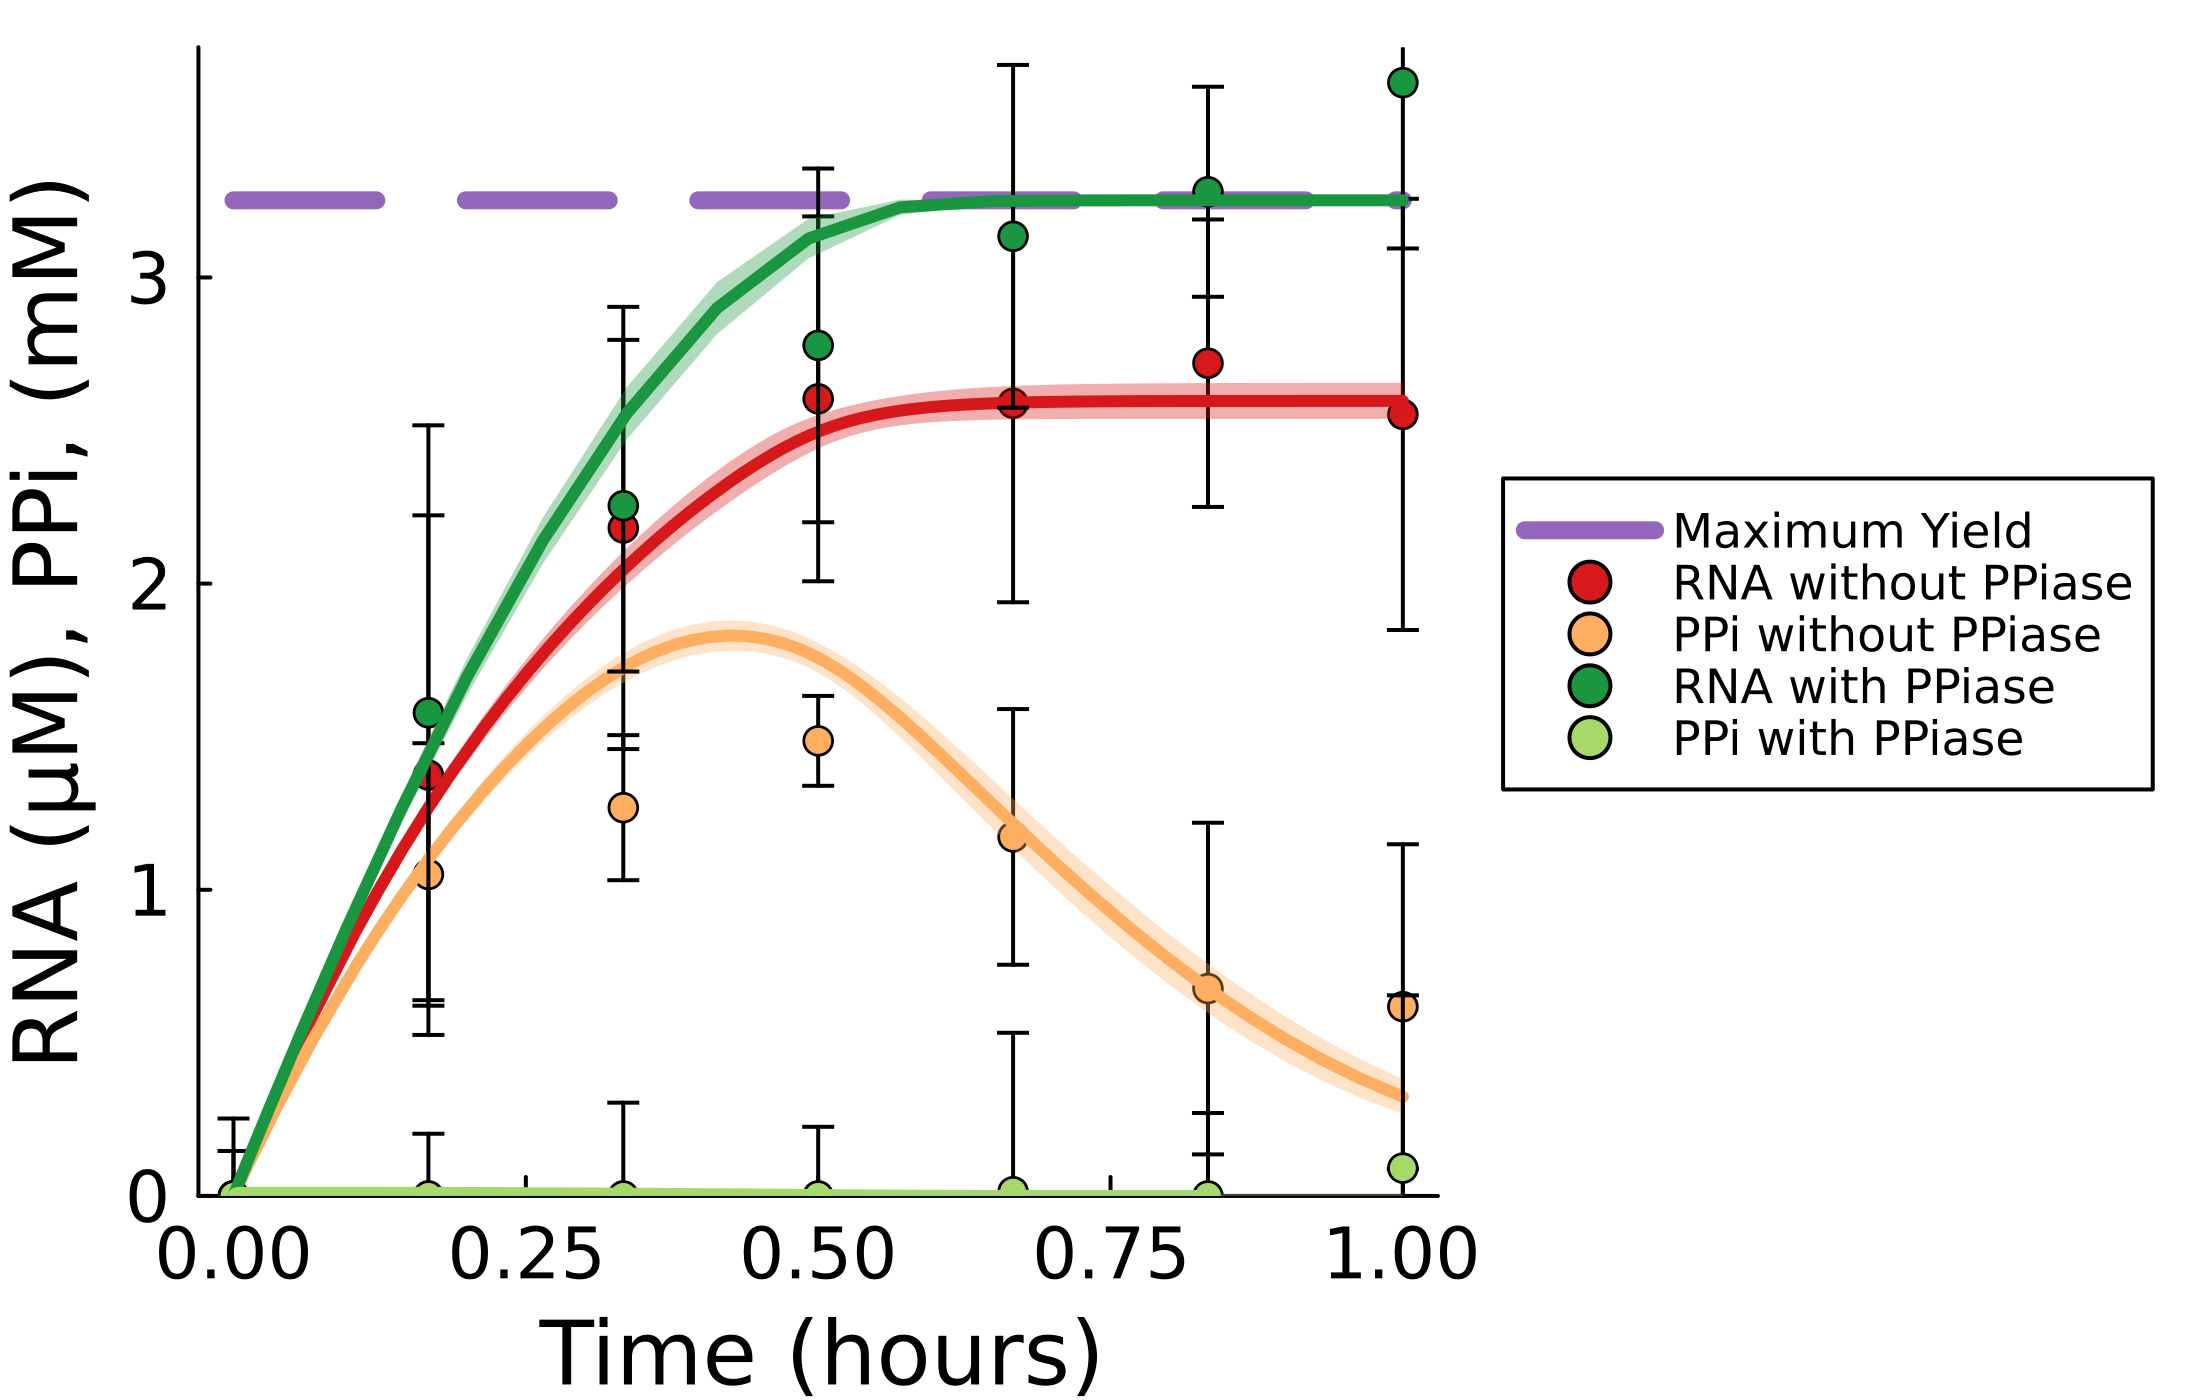

In [360]:
plt= plotakamaPPiase(PPiasedata, fittedparams, covariancemat,fittingmodel)
plot!(dpi = 400)
savefig(plt,"../figures/GM6_27/ppiaseval.png")
plt

In [361]:
df = CSV.read("../data/external/guo/guoMgNTP.csv", DataFrame)
guodata = Matrix(df)

df = CSV.read("../data/akama_data/akamaMgNTP.csv", DataFrame)
akamadata = Matrix(df);

In [362]:
testlist = fittedparamslist

24-element Vector{Float64}:
  3.9984820568212043
  3.248403297602814
  5.182445308339995
  5.9364870563559275
  3.0470683026945853
 -3.580408207494102
 -5.5517918200206475
  1.1818832771539571
 -4.257829165074149
  1.5876447555465423
  1.1162132752869587
 -7.255212000951606
 -9.4236207847544
  1.0924417345209245
  0.0
  0.5283193174269077
  1.63377699099772
  4.576526496045724
  3.2583144808442857
  3.869221969838677
  1.6378381746482422
  4.987152756896689
  3.7153100989813748
 -3.9073570114042835

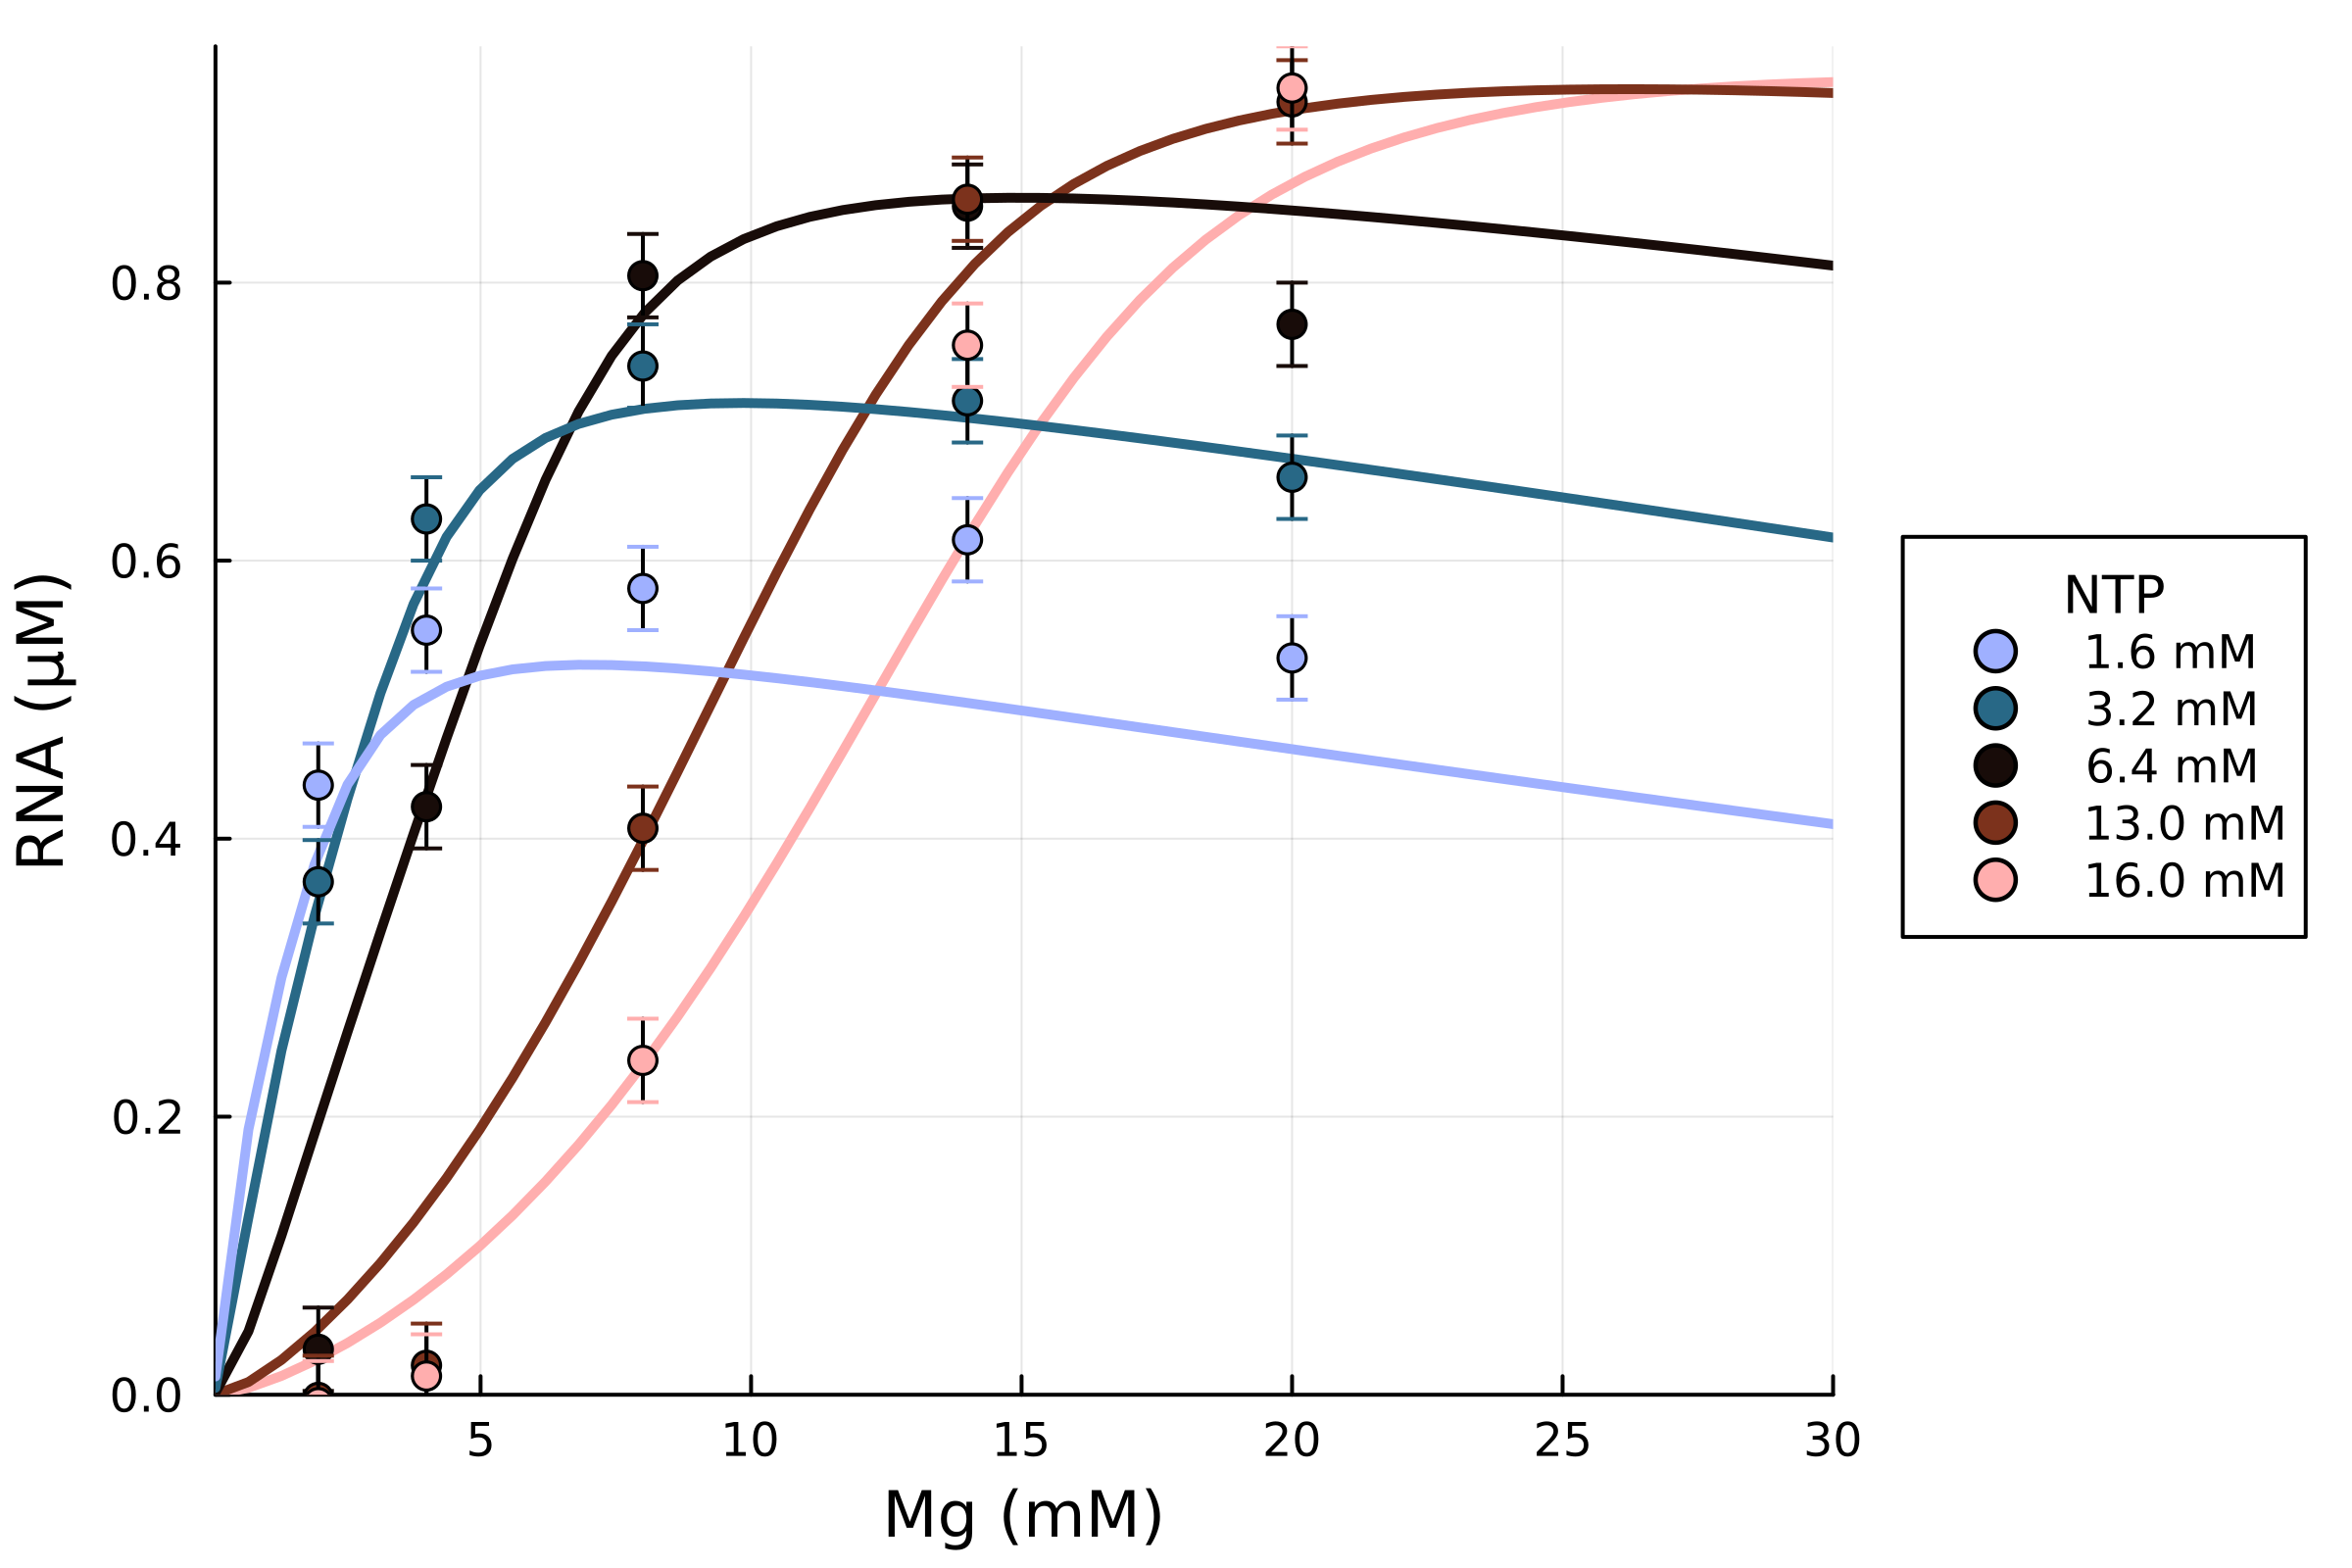

In [363]:
plt = plotbyMg(fittingmodel,akamadata,testlist, covariancemat;showconfidence = false,T7RNAP = 1e-7, DNA = 7.4, finaltime = 5/60, PPiase = 0, stoich = (231,246,189,202), datastddev = 0.03,Mgrange = (0.1e-3,30e-3), nmc = 500, OAccounterion = true)
plot!(dpi = 400)
savefig(plt,"../figures/GM6_27/akamaratetrans.png")
plt

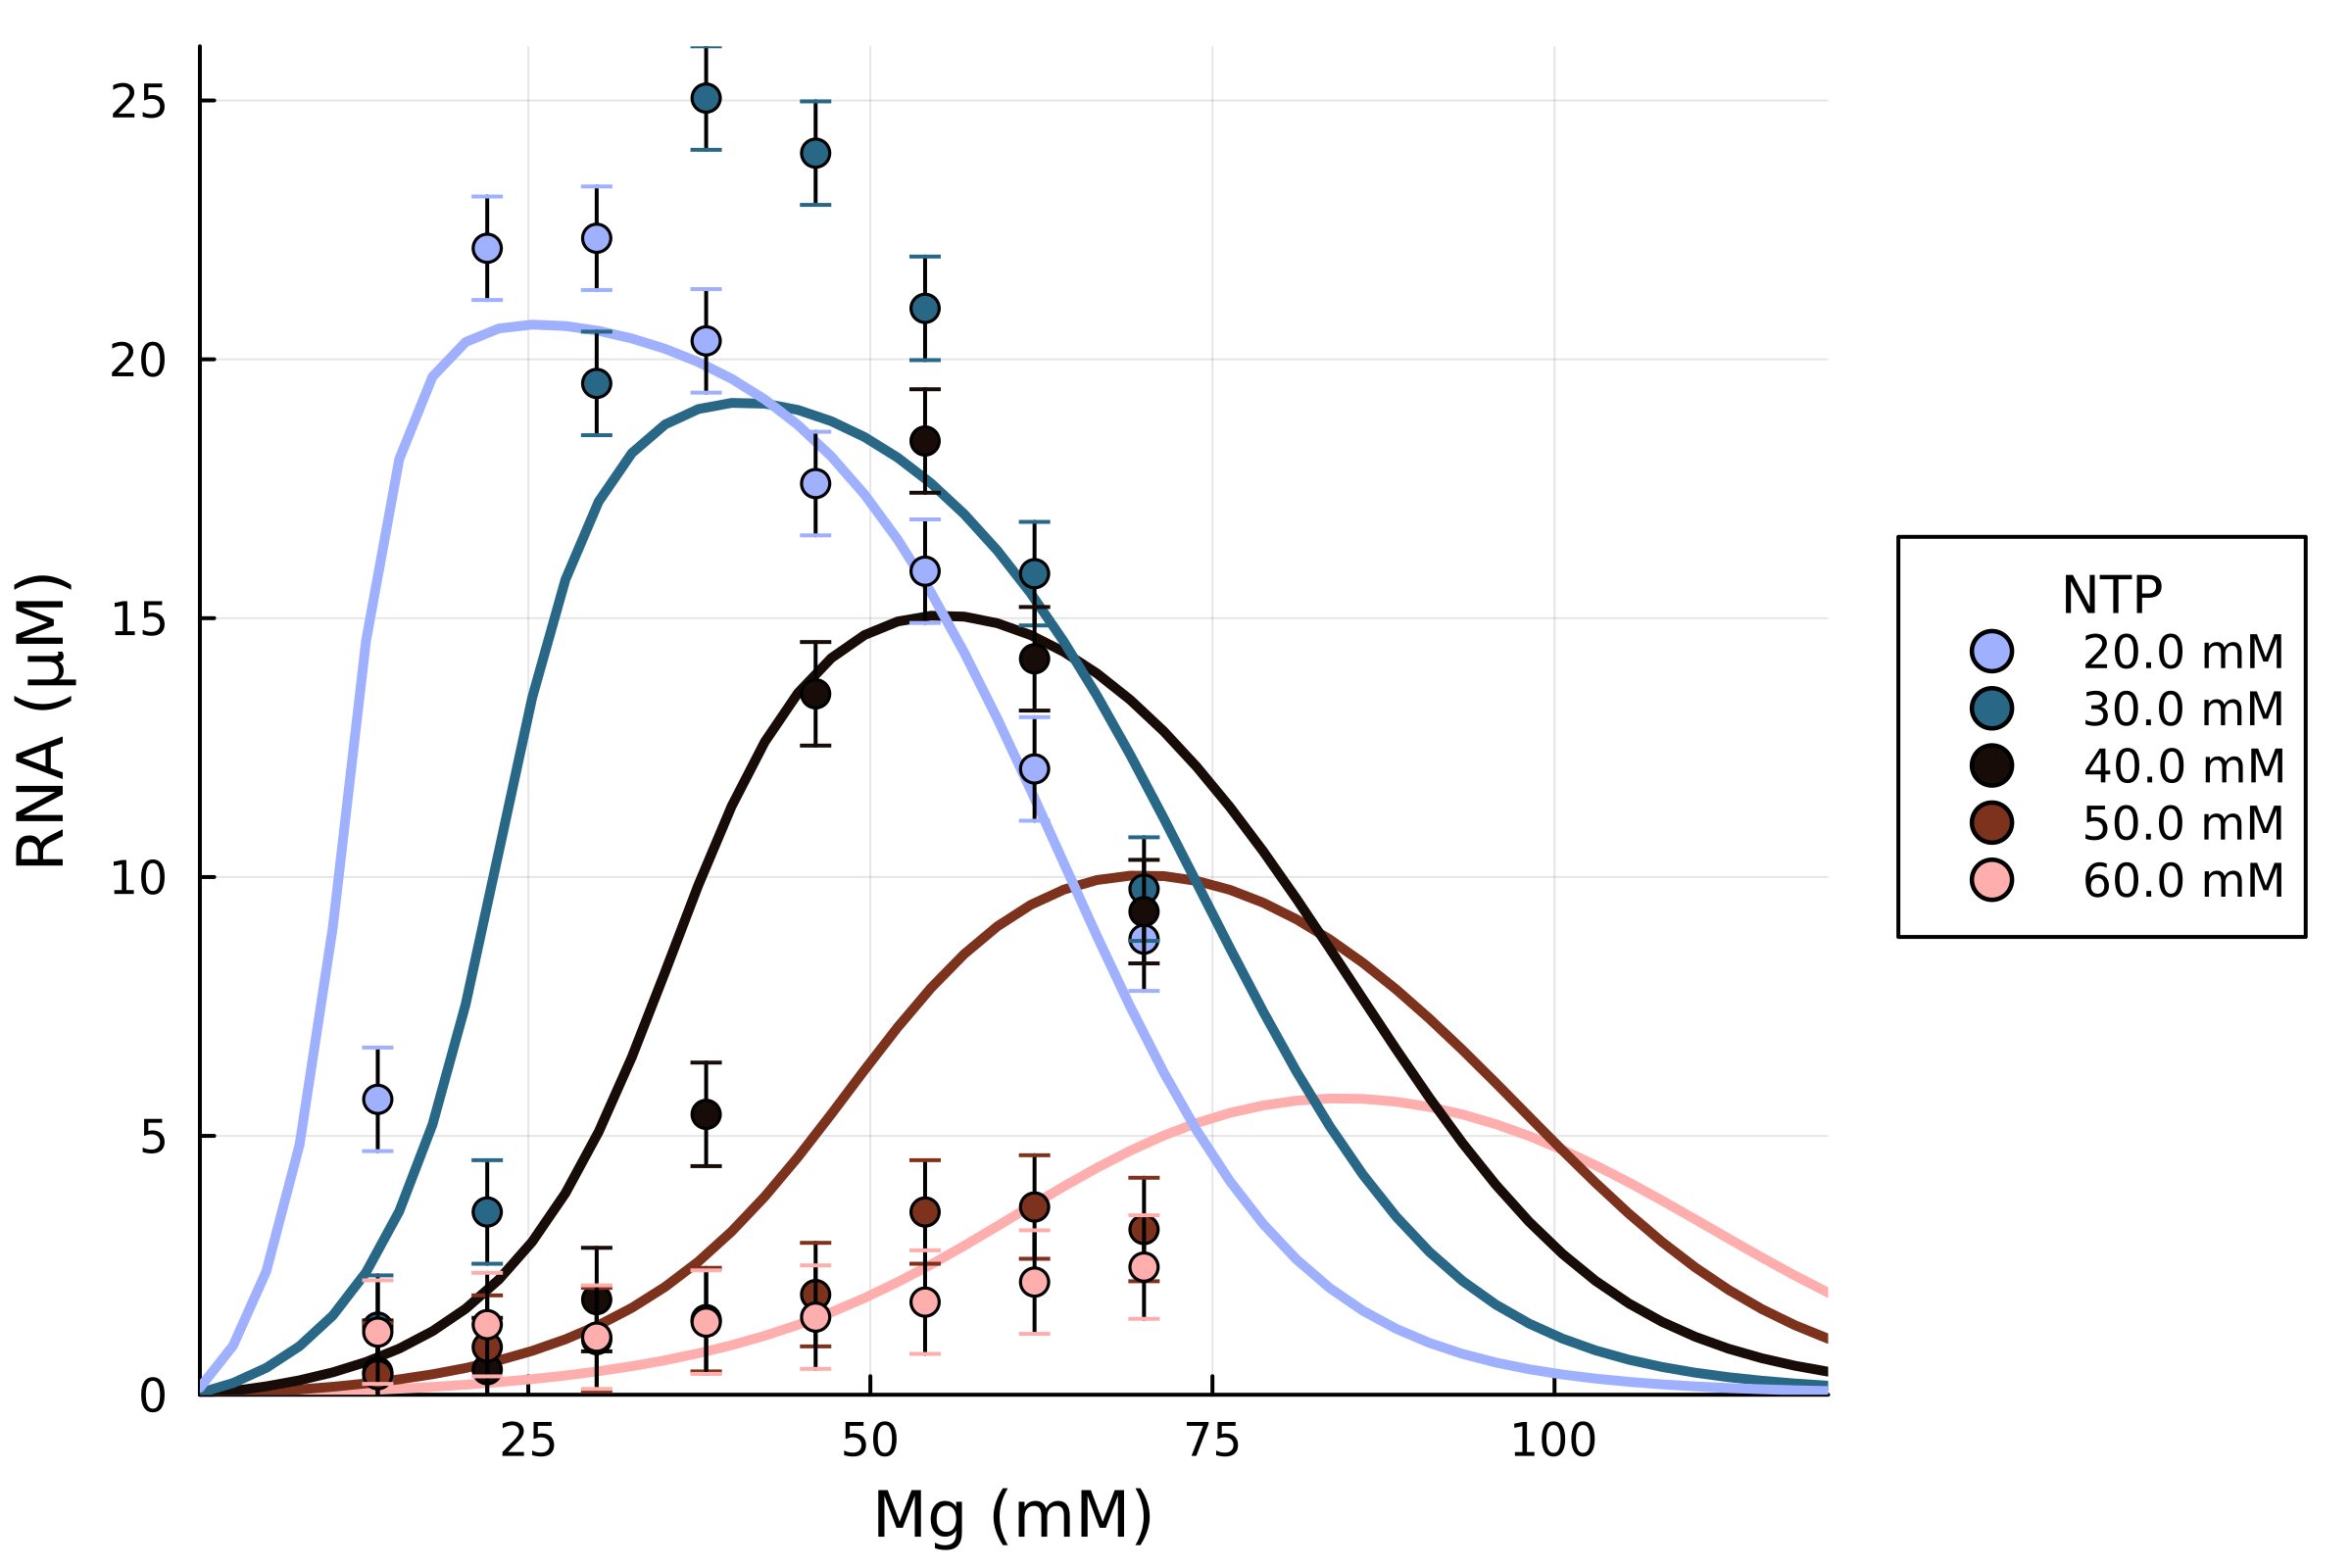

In [364]:
plt = plotbyMg(fittingmodel,guodata,testlist , covariancemat;showconfidence = false, seperateDNA = true, OAccounterion = false, showpredictions = true)
plot!(dpi = 400)
savefig(plt,"../figures/GM6_27/guomain.png")
plt

<b>Validation?<b>

In [41]:
pfizerls =   [4.001471165141637
  3.0104368697941376
  5.160590650718022
  5.845317908596088
  2.8166058193996895
 -3.6394231027354427
 -7.075595325565645
  1.3979400086720377
 -4.400306948754228
  1.6261071530202857
  1.1452813957385837
 -7.1995628501078786
 -9.445400959521441
  1.0809524026815467
  6.063955609464895e-29
  0.6416119280911703
  1.6347192995659983
  4.604626269868236
  3.1129976887750446
  3.8538737086530745
  5.020301797322221
  3.7065277023523486
 -3.8908196040406726]

23-element Vector{Float64}:
  4.001471165141637
  3.0104368697941375
  5.160590650718022
  5.845317908596088
  2.8166058193996895
 -3.6394231027354427
 -7.075595325565645
  1.3979400086720377
 -4.400306948754228
  1.6261071530202857
  1.1452813957385837
 -7.1995628501078786
 -9.445400959521441
  1.0809524026815467
  6.063955609464895e-29
  0.6416119280911703
  1.6347192995659983
  4.604626269868236
  3.1129976887750446
  3.8538737086530745
  5.020301797322221
  3.7065277023523486
 -3.8908196040406726

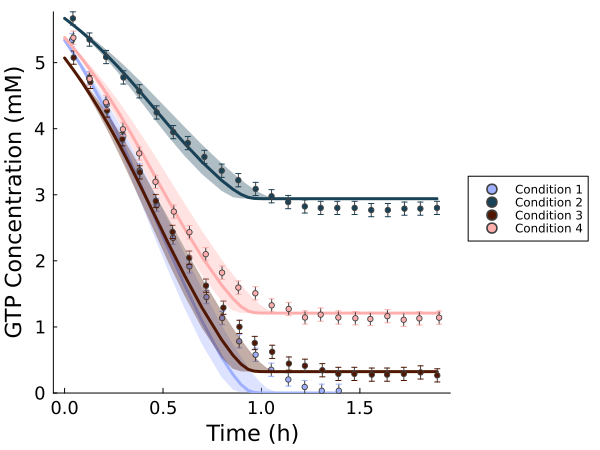

In [42]:
pfizerfilename = "../data/external/pfizer/pfizerNTP.csv"
plt = plotfromcsv(fittingmodel,pfizerls,covariancemat,pfizerfilename,range = [1,2,3,4],plotsize = (600,450),dataerrorbars = true, multiplot = false,maximumyield = false, precip = true, seperateDNA = true)

In [24]:
fittedparams

ComponentVector{Float64}(k_dT7 = 0.0, k_i = 9960.683593716232, k_i_guo = 4042.891781136593, k_e = 144792.86093250973, k_e_guo = 705781.569266394, k_off = 4320.0, k_on = 684.5617216039284, K_1 = 0.0002302253035809988, K_2 = 8.379721058124793e-8, nMg = 25.000000000000007, Ki_PPi = 4.068530441598186e-5, K_Mg = 42.082511534880226, K_u0 = 14.116337044532205, K_a = 6.309811371613115e-8, K_b = 3.591993805823907e-10, k_pH = 12.060337390654354, gamma = 1.0, theta = 0.0208, K_ds = 1.0, kPPiase = 1.0, KMPPiase = 0.000214, k_precip = 4.452820986187911, B = 43.529469521536534, k_d = 40675.61841199413, K_HNTP = 3.0669027151623075e6, K_HMgNTP = 101.93421904967055, K_HPPi = 1.0471285480508986e9, K_HMgPPi = 1138.269999895762, K_H2PPi = 1.8197008586099825e6, K_H2MgPPi = 128.82495516931337, K_MgNTP = 7151.618810429667, K_Mg2NTP = 40.26243159764699, K_MgPPi = 107186.13352722046, K_Mg2PPi = 4962.794571500765, Mg2PPi_eq = 0.0001273866998114784, K_MgPi = 43.19592714369777, K_HPi = 4.171987514076607e6, K_NaPi